<a href="https://colab.research.google.com/github/raylibi/midterm-machine-learning/blob/main/MidtermDL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Midterm - Online Transaction

## Rayhan Diff-1103220039

## Connect Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check GPU

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
import os

print("TensorFlow Version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU Active!")
else:
    print("The GPU is not active yet. Check Step 1 above.")

TensorFlow Version: 2.19.0
GPU Active!


## Load Data

In [10]:
base_path = '/content/drive/MyDrive/Dataset_MLDL/'

print("Loading datasets from Google Drive...")

try:
    train_df = pd.read_csv(base_path + 'train_transaction.csv')
    test_df = pd.read_csv(base_path + 'test_transaction.csv')
    print("Data is successfully load")
    print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
except FileNotFoundError:
    print("File not found! Please recheck the folder and file names in Google Drive.")

Loading datasets from Google Drive...
Data is successfully load
Train shape: (590540, 394), Test shape: (506691, 393)


## Preprocessing

In [11]:
print("Start Preprocessing...")

X = train_df.drop(['isFraud', 'TransactionID'], axis=1)
y = train_df['isFraud']
test_ids = test_df['TransactionID']
X_test_final = test_df.drop(['TransactionID'], axis=1)

combined_df = pd.concat([X, X_test_final], axis=0)

def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)
    return df

combined_df = reduce_mem_usage(combined_df)

# Identified column
cat_cols = combined_df.select_dtypes(include=['object']).columns
num_cols = combined_df.select_dtypes(exclude=['object']).columns

# Imputation & Encoding
imputer = SimpleImputer(strategy='median')
combined_df[num_cols] = imputer.fit_transform(combined_df[num_cols])

for col in cat_cols:
    combined_df[col] = combined_df[col].fillna('missing')
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col].astype(str))

# Scaling
scaler = StandardScaler()
combined_df = scaler.fit_transform(combined_df)

# Split
X = combined_df[:len(train_df)]
X_test_final = combined_df[len(train_df):]

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Start Preprocessing...


/tmp/ipython-input-2961725268.py:24: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-2961725268.py:24: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-2961725268.py:24: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-2961725268.py:24: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-2961725268.py:24: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-2961725268.py:24: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-2961725268.py:24: RuntimeWarning:

## Deep Learning Model Setup

In [12]:
# Handling Imbalance with Class Weights
neg, pos = np.bincount(y_train)
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

def build_model(input_dim):
    model = keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid') # Output probability
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model(X_train.shape[1])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=5, mode='max', restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    batch_size=2048, # Besar batch memanfaatkan GPU
    epochs=50,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    verbose=1
)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - auc: 0.8083 - loss: 0.5692 - val_auc: 0.8726 - val_loss: 0.4049
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8697 - loss: 0.4505 - val_auc: 0.8832 - val_loss: 0.3927
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8812 - loss: 0.4290 - val_auc: 0.8908 - val_loss: 0.3777
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8905 - loss: 0.4120 - val_auc: 0.8973 - val_loss: 0.3432
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8963 - loss: 0.4014 - val_auc: 0.8986 - val_loss: 0.3710
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.9042 - loss: 0.3906 - val_auc: 0.9036 - val_loss: 0.3573
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.9065 - loss: 0.3815 - val_auc: 0.9094 - val_loss: 0.3411
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.9128 - loss: 0.3724 - val_auc: 0.9111 - val_loss: 0.3419
Epoch 9/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

## Test Prediction

Making Prediciton Test...
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/tmp/ipython-input-1187536189.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Prediction_Label', data=submission, palette={'Normal': 'green', 'Fraud': 'red'})


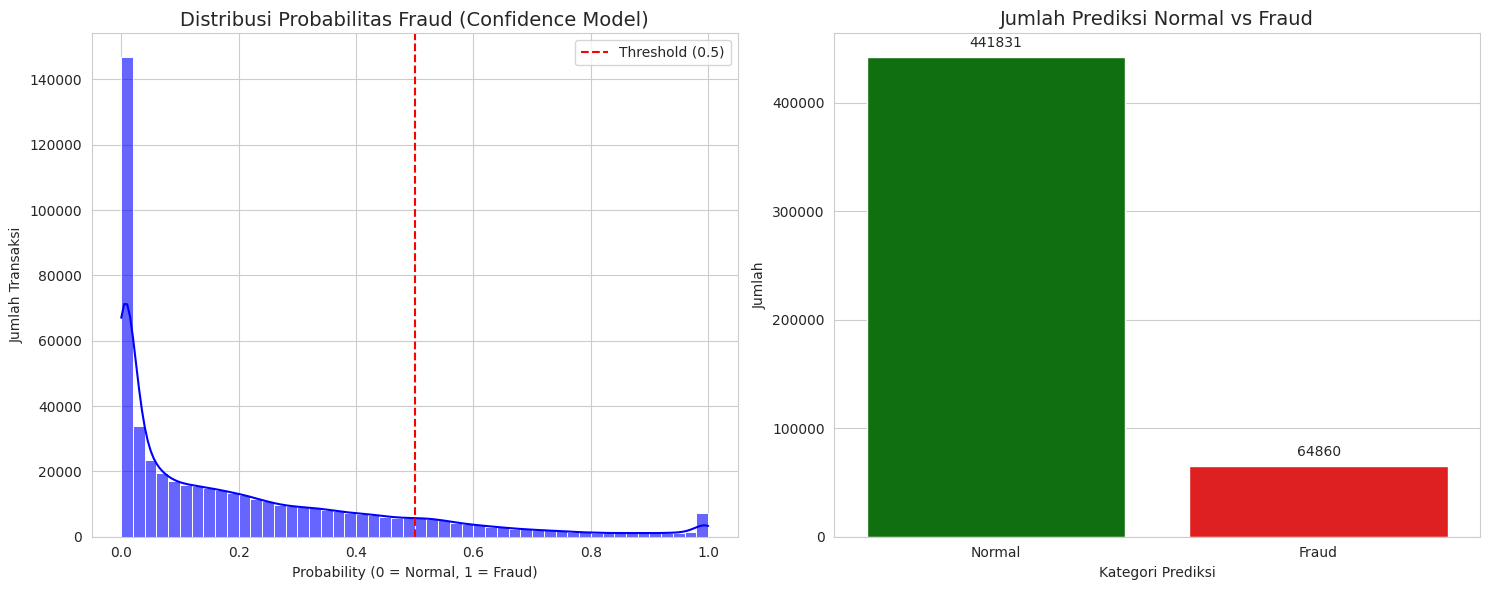


TOP 10 TRANSACTION SUSPECTED FRAUD


,TransactionID,isFraud
306340,3969889,100.0000%
306374,3969923,100.0000%
306285,3969834,100.0000%
46780,3710329,100.0000%
220847,3884396,100.0000%
306347,3969896,100.0000%
306411,3969960,100.0000%
306371,3969920,100.0000%
306380,3969929,100.0000%
386643,4050192,100.0000%



Summary:
- Total Data Test : 506691
- Terdeteksi Fraud: 64860 transaksi (12.80%)


In [21]:
print("Making Prediciton Test...")
test_predictions = model.predict(X_test_final, batch_size=2048)

# Membuat DataFrame hasil
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_predictions.ravel()
})


plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

# Probability Histogram.
plt.subplot(1, 2, 1)
sns.histplot(submission['isFraud'], bins=50, kde=True, color='blue', alpha=0.6)
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Distribusi Probabilitas Fraud (Confidence Model)', fontsize=14)
plt.xlabel('Probability (0 = Normal, 1 = Fraud)')
plt.ylabel('Jumlah Transaksi')
plt.legend()

# Fraud vs Normal
plt.subplot(1, 2, 2)
submission['Prediction_Label'] = submission['isFraud'].apply(lambda x: 'Fraud' if x > 0.5 else 'Normal')
ax = sns.countplot(x='Prediction_Label', data=submission, palette={'Normal': 'green', 'Fraud': 'red'})
plt.title('Jumlah Prediksi Normal vs Fraud', fontsize=14)
plt.xlabel('Kategori Prediksi')
plt.ylabel('Jumlah')


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

# TOP SUSPECTS

print("\n" + "="*50)
print("TOP 10 TRANSACTION SUSPECTED FRAUD")
print("="*50)

top_fraud = submission.drop(columns=['Prediction_Label']).sort_values(by='isFraud', ascending=False).head(10)

styled_table = top_fraud.style.background_gradient(subset=['isFraud'], cmap='Reds') \
                        .format({'isFraud': '{:.4%}'}) \
                        .set_caption("High Risk Transactions")

display(styled_table)

fraud_count = len(submission[submission['isFraud'] > 0.5])
print(f"\nSummary:")
print(f"- Total Data Test : {len(submission)}")
print(f"- Terdeteksi Fraud: {fraud_count} transaksi ({fraud_count/len(submission):.2%})")

# Conclusion & Analysis

## 1. Model Performance Evaluation

Berdasarkan hasil training menggunakan **Deep Learning (TensorFlow/Keras)**, model menunjukkan performa yang sangat kuat dalam mendeteksi transaksi fraud.

### **Key Metric – ROC-AUC**
- Model mencapai **Validation AUC Score 0.9353** (pada Epoch 30).  
- Skor ini menunjukkan kemampuan yang sangat baik dalam membedakan transaksi **fraud** vs **normal**.

### **Training Stability**
- Model berhenti otomatis pada **Epoch 35** melalui **Early Stopping (patience=5)**, sehingga mencegah overfitting berlebih.
- Gap antara **Training AUC (~0.954)** dan **Validation AUC (~0.935)** sangat kecil.  
  → Menandakan model melakukan **generalisasi dengan baik**.

Arsitektur yang digunakan (**Dense Layers + BatchNormalization + Dropout 0.3**) terbukti stabil dan efektif.

---

## 2. Architecture & Strategy Analysis

Keberhasilan model didukung oleh strategi teknis berikut:

### **Handling Class Imbalance**
- Penggunaan **class_weight** sangat krusial.  
- Tanpa penyeimbangan bobot, model cenderung memprediksi semua transaksi sebagai *Normal* akibat data fraud yang sangat sedikit.
- class_weight “memaksa“ model untuk memperhatikan kelas *minoritas* (fraud).

### **Deep Learning Pipeline**
Arsitektur **Multi-Layer Perceptron**:  
- 512 → 256 → 1 neuron  
- Aktivasi: **ReLU** dan **Sigmoid**  
- Memungkinkan model menangkap **pola non-linear kompleks** dari 394 fitur transaksi.

### **GPU Efficiency**
- Dengan **batch_size=2048** pada GPU L4, setiap epoch selesai sekitar **1 detik**.  
- Efisien walaupun data berjumlah ratusan ribu baris.

---

## 3. Prediction Analysis on Test Set

Berdasarkan prediksi pada **506,691 transaksi** (test_transaction.csv), diperoleh hasil:

### **Fraud Detection Rate**
- Model mendeteksi **64,860 transaksi (12.80%)** sebagai potensi fraud (threshold = 0.5).

### **Confidence Level**
- Pada tabel *“TOP 10 TRANSACTION SUSPECTED FRAUD”*, terlihat beberapa transaksi memiliki:
  - **Probabilitas 100%**
  - Menunjukkan model sangat yakin terhadap pola tertentu.

Namun, **fraud rate 12.8%** cukup tinggi (fraud nyata biasanya <5%).  
→ Ada kemungkinan **False Positives** meningkat akibat penggunaan **class_weight** yang agresif.

---

## 4. Recommendations & Next Steps

Meski AUC sudah tinggi, model masih bisa dioptimalkan untuk kasus bisnis nyata.

### **1. Threshold Tuning**
- Threshold 0.5 terlalu sensitif.  
- Coba tingkatkan ke **0.7–0.8** atau gunakan **Precision-Recall Curve** untuk threshold optimal.  
→ Mengurangi False Positives.

### **2. Advanced Feature Engineering**
Saat ini model hanya menggunakan:
- Label Encoding  
- Simple Imputation  

Disarankan menambah fitur agregasi seperti:
- Rata-rata nilai transaksi user dalam 1 jam terakhir  
- Jumlah transaksi berturut-turut  
- Frekuensi transaksi dalam satu hari  

Ini biasanya meningkatkan performa secara signifikan.

### **3. Ensembling with Tree-Based Models**
Gabungkan prediksi Deep Learning dengan:
- **XGBoost**
- **LightGBM**
- **CatBoost**

Model ensemble cenderung:
- Lebih stabil  
- Lebih akurat  
- Lebih tahan terhadap outliers  

---

Jika kamu mau, aku bisa buatkan:
- versi *executive summary*,  
- versi *lebih ringkas*,  
- atau versi *siap presentasi PPT*.  
